# Display Accuracy and Loss

## Load Data

In [15]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os
# _path = '.'
# sys.path.append(os.path.join(_path))
import matplotlib.pyplot as plt

def parse_tf_events_file(events_path, tag, time_horizon=None):
    ea = EventAccumulator(events_path).Reload()
    print(ea)
    tag_values, steps = [], []
    for event in ea.Scalars(tag):
        if time_horizon is None or event.step <= time_horizon:
            tag_values.append(event.value)
            steps.append(event.step)
    return steps, tag_values

class ExperimentConfig:
    def __init__(self, base_path, experiment, seeds, algorithms, events, lr_list,
                 alphas, n_clients_list, availabilities, n_rounds, participations, biased_list):
        """
        base_path: path to the folder logs/
        experiment: name of exp (str: mnist_CI_based_availability)
        seeds: list of seeds
        algorithms: list of algorithms
        events: list of events (e.g. ["global"])
        # b_values:
        lr_list: list of learning rates
        alphas: list of alpha values (for the iid - non iid -ness)
        n_clients_list: list of number of clients
        availabilities: list of availability types
        n_rounds: number of FL rounds
        participations: list with "unknown" and/or "known" (whether we work with the participation probabilities estimator or the true values)
        biased: list of elements of {0, 1} (0=unbiased, 1=biased)
        """
        self.base_path = base_path
        self.experiment = experiment
        self.seeds = seeds
        self.algorithms = algorithms
        self.events = events
        # self.b_values = b_values
        self.lr_list = lr_list
        self.alphas = alphas
        self.n_clients_list = n_clients_list
        self.availabilities = availabilities
        self.n_rounds = n_rounds
        self.participations = participations
        self.biased_list = biased_list

    def get_event_dir(self, algo, lr, seed, event, alpha, n_clients, availability, n_rounds, participation, biased):
        """
        Returns the path to the saved data corresponding to the parameters given as inputs to this function.
        Intputs:
        algorithm: algorithm (str:fedavg, defvarp or fedstale)
        lr: learning rate (str)
        b: beta (str)
        seed:
        event:
        alpha:
        n_clients:
        availability:
        n_rounds:
        participation:
        biased: 0 or 1 (str)
        """
        path = f"{self.base_path}/{self.experiment}/clients_{n_clients}/{availability}"
        # path += f"/{algo}/b_{b}" if algo == "mixture" else f"/{algo}" # in case we vary beta
        path += f"/biased_{biased}/{algo}/{participation}_participation_probs"
        path += f"/alpha_{alpha}/lr_{lr}/seed_{seed}/rounds_{n_rounds}/train/{event}"

        path = os.path.join(self.base_path, self.experiment, "clients_"+n_clients, availability,
                            "biased_"+biased, algo, participation+"_participation_probs", "alpha_"+alpha,
                            "lr_"+lr, "seed_"+seed, "rounds_"+n_rounds, "train", event)

        # path = '/'.join([self.base_path, self.experiment, "clients_"+n_clients, availability,
        #                     "biased_"+biased, algo, participation+"_participation_probs", "alpha_"+alpha,
        #                     "lr_"+lr, "seed_"+seed, "rounds_"+n_rounds, "train", event])

        return path

# Load and Process Experiment Results
def load_experiment_results(config):
    results = [] 
    for lr in tqdm(config.lr_list, desc="Processing experiments"):
        # time_horizon = time_horizons[p]  
        for algorithm in config.algorithms:
            # b_loop = config.b_values if algorithm == 'mixture' else [None] # in case we vary beta
            # for b in b_loop:
            for event in config.events:
                for seed in config.seeds:
                    for a in config.alphas:
                        for n_c in config.n_clients_list:
                            for av in config.availabilities:
                                for part in config.participations:
                                    for biased in config.biased_list:

                                        event_dir = config.get_event_dir(algorithm, lr, seed, 
                                                                            event, a, n_c, av, 
                                                                            config.n_rounds, part, biased) 

                                        print(event_dir)                                   
                                        files = os.listdir(event_dir)
                                        print(files)

                                        if os.path.exists(event_dir):
                                            # print('x')
                                            # _, values = parse_tf_events_file(event_dir, tag="Test/Metric", time_horizon=time_horizon)
                                            _, test_accuracy_values = parse_tf_events_file(event_dir, tag="Test/Metric")
                                            _, test_loss_values = parse_tf_events_file(event_dir, tag="Test/Loss")
                                            _, train_accuracy_values = parse_tf_events_file(event_dir, tag="Train/Metric")
                                            _, train_loss_values = parse_tf_events_file(event_dir, tag="Train/Loss")
                                            ### tag can be: 'Train/Loss', 'Train/Metric', 'Test/Loss', 'Test/Metric'
                                            max_accuracy = np.array(test_accuracy_values).max() * 100
                                            results.append({
                                                "algorithm": algorithm, "availability": av,
                                                "alpha": a, "participation": part,
                                                "max_test_accuracy": float(max_accuracy),
                                                "test_accuracy": "Test/Metric",
                                                "test_loss": "Test/Loss",
                                                "train_accuracy": "Train/Metric",
                                                "train_loss": "Train/Loss",
                                                "seed": seed,
                                                "lr": lr, "event": event, "n_clients": n_c,
                                                "biased": biased
                                                # "event_dir": event_dir
                                            })

                                            # "b": float(b) if b else np.nan # in case we vary beta
    return pd.DataFrame(results)

## Plots

In [16]:
# import matplotlib.pyplot as plt

# def plot_availability_comparison(config, res, metric):

    
#     xvalues = [i for i in range(int(config.n_rounds)+1)]

#     for lr in config.lr_list:
#         for algo in config.algorithms:
#             for event in config.events:
#                 for seed in config.seeds:
#                     for a in config.alphas:
#                         for n_c in config.n_clients_list:
#                             # for av in config.availabilities:
#                             for part in config.participations:


#                                     res_tmp = res[(res.lr == lr) & (res.algorithm == algo) & (res.event == event) &
#                                                 (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
#                                                 (res.participation == part)]
                                    
#                                     # display(res_plot) # this is what we are going to compare
                                    
#                                     fig = plt.figure(figsize=(6, 4))
#                                     for av in config.availabilities:
#                                         if 'random' in av:
#                                             res_plot = res_tmp[res_tmp.availability == av]
#                                             event_dir = config.get_event_dir(algo, lr, seed, 
#                                                                             event, a, n_c, av, 
#                                                                             config.n_rounds, part)  
#                                             # display(res_plot)
#                                             # print('xxx')
#                                             tag = res_plot[metric].values[0]
#                                             _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
#                                             # print(av)
#                                             # yvalues = res_plot[(res_plot.availability == av)][metric]
#                                             # print(res_plot[(res_plot.availability == av)][metric])
#                                             plt.plot(xvalues, test_accuracy_values, label= av)
#                                             title = ('_').join([algo, 'alpha'+a, 'random', metric])
#                                             plt.title(title)
#                                     plt.legend()
#                                     plt.grid()
#                                     plt.savefig('figures/accross_availabilities/'+title+'.png', bbox_inches='tight')
#                                     plt.show()

#                                     fig = plt.figure(figsize=(6, 4))
#                                     for av in config.availabilities:
#                                         if 'random' not in av:
#                                             res_plot = res_tmp[res_tmp.availability == av]
#                                             event_dir = config.get_event_dir(algo, lr, seed, 
#                                                                             event, a, n_c, av, 
#                                                                             config.n_rounds, part)  
#                                             # display(res_plot)
#                                             # print('xxx')
#                                             tag = res_plot[metric].values[0]
#                                             _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
#                                             # print(av)
#                                             # yvalues = res_plot[(res_plot.availability == av)][metric]
#                                             # print(res_plot[(res_plot.availability == av)][metric])
#                                             plt.plot(xvalues, test_accuracy_values, label= av)
#                                             title = ('_').join([algo, 'alpha'+a, metric])
#                                             plt.title(title)
#                                     plt.legend()
#                                     plt.grid()
#                                     plt.savefig('figures/accross_availabilities/'+title+'.png', bbox_inches='tight')
#                                     plt.show()
    
# plot_availability_comparison(config, results_df, "test_accuracy")

## Plot Unbiased/Biased comparison

In [17]:
# config for first biased/unbiased comparison:
# config = ExperimentConfig(base_path=os.path.join('.', 'logs'), experiment="mnist_CI_based_availability", seeds=["12"],
#                           algorithms=["fedavg", "fedvarp", "fedstale"], events=["global"],
#                           lr_list=["5e-3"], alphas=["0.1", "100000"], n_clients_list=["7"],
#                           availabilities=["carbon-budget-fine-tuning", "random_for_carbon-budget-fine-tuning"],
#                           n_rounds="100", participations=["known"], biased_list=["0", "1"]
#                          )

config = ExperimentConfig(base_path=os.path.join('.', 'logs'), experiment="mnist_CI_based_availability_comp_new_opti_pb", seeds=["12"],
                          algorithms=["fedavg", "fedvarp", "fedstale"], events=["global"],
                          lr_list=["5e-3"], alphas=["100000", "0.1"], n_clients_list=["7"],
                          availabilities=["opt-new-problem-cvxpy_a-1",
                                          "opt-new-problem-cvxpy_a-10",
                                          "opt-new-problem-cvxpy_a-21",
                                          "uniform-CI-threshold", 
                                          "uniform-carbon-budget", 
                                          "uniform-carbon-budget-ft", 
                                          "uniform-time-budget"],
                          n_rounds="100", participations=["known"], biased_list=["0", "1", "2"]
                         )

results_df = load_experiment_results(config)

Processing experiments:   0%|          | 0/1 [00:00<?, ?it/s]

.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\opt-new-problem-cvxpy_a-1\biased_0\fedavg\known_participation_probs\alpha_100000\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721721750.C11-8C4G9B45HOX.5908.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\opt-new-problem-cvxpy_a-1\biased_1\fedavg\known_participation_probs\alpha_100000\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721805664.C11-8C4G9B45HOX.19600.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\opt-new-problem-cvxpy_a-1\biased_2\fedavg\known_participation_probs\alpha_100000\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721810225.C11-8C4G9B45HOX.14140.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\opt-new-problem-cvxpy_a-10\biased_0\fedavg\known_participation_probs\alpha_100000\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721722264.C11-8C4G9B45HOX.29264.7']
.\logs\mnist_CI_based_availabili

Processing experiments: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\uniform-carbon-budget-ft\biased_0\fedstale\known_participation_probs\alpha_0.1\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721833538.C11-8C4G9B45HOX.4012.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\uniform-carbon-budget-ft\biased_1\fedstale\known_participation_probs\alpha_0.1\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721844075.C11-8C4G9B45HOX.33004.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\uniform-carbon-budget-ft\biased_2\fedstale\known_participation_probs\alpha_0.1\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721902740.C11-8C4G9B45HOX.24580.7']
.\logs\mnist_CI_based_availability_comp_new_opti_pb\clients_7\uniform-time-budget\biased_0\fedstale\known_participation_probs\alpha_0.1\lr_5e-3\seed_12\rounds_100\train\global
['events.out.tfevents.1721834026.C11-8C4G9B45HOX.10248.7']
.\logs\mnist_CI_based_availability_comp_new_op

Processing experiments: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


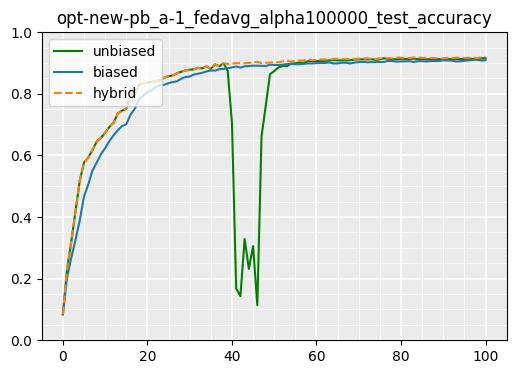

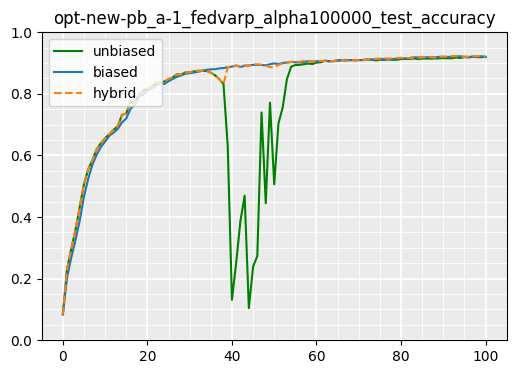

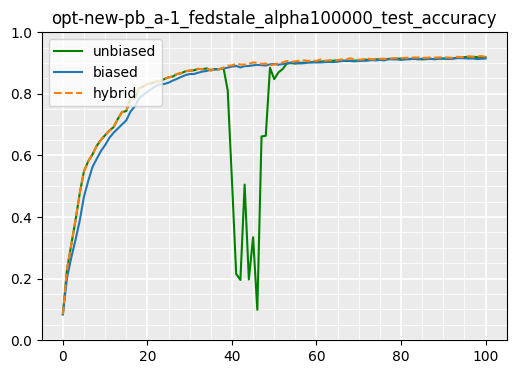

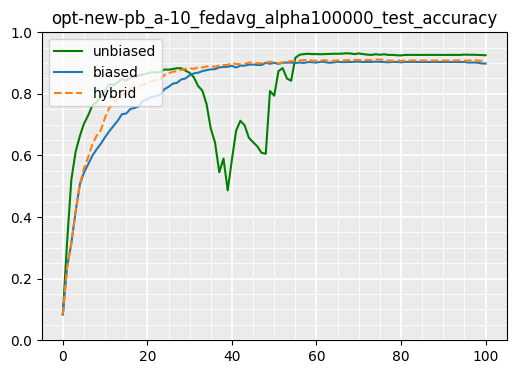

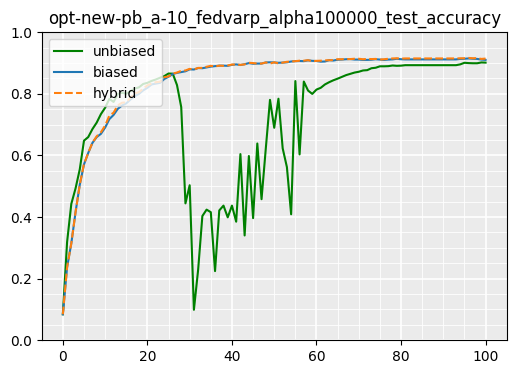

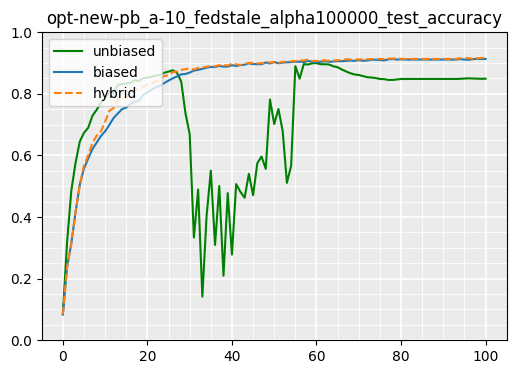

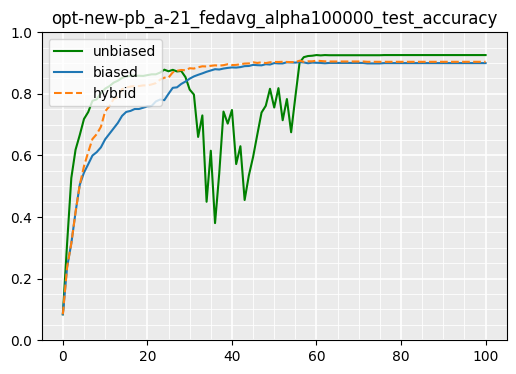

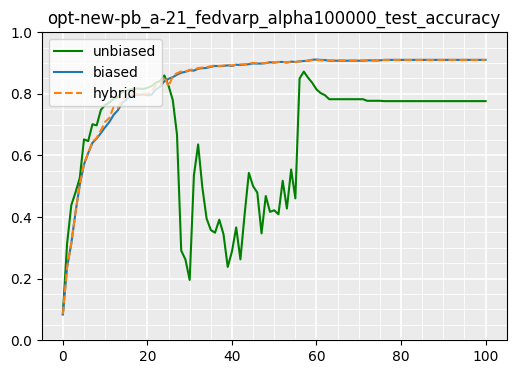

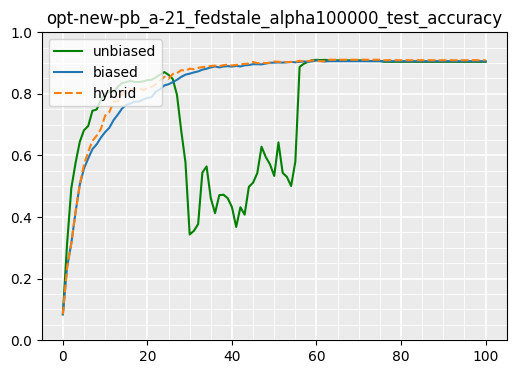

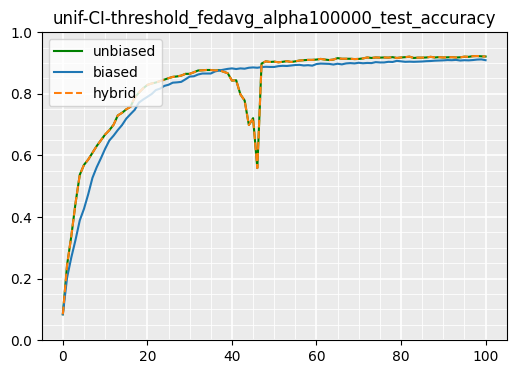

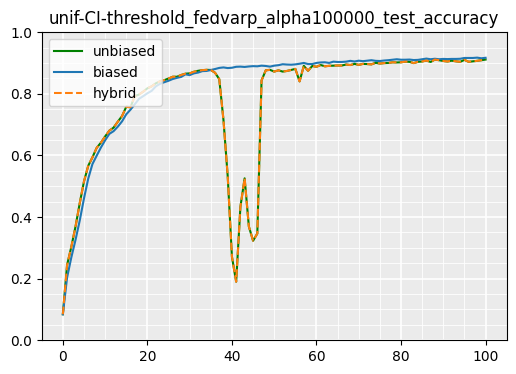

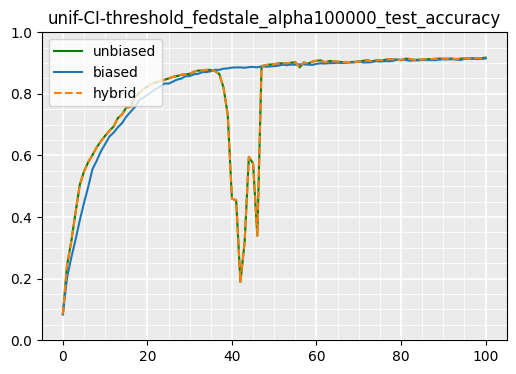

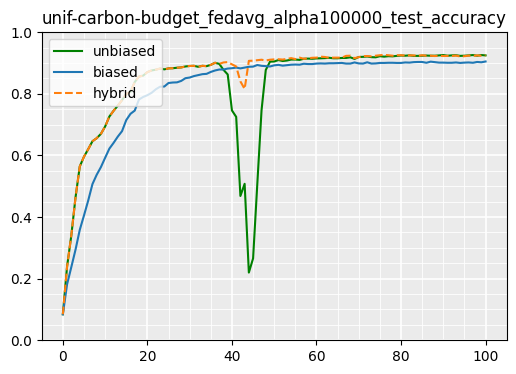

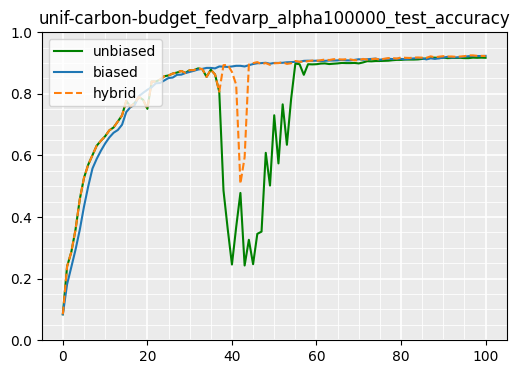

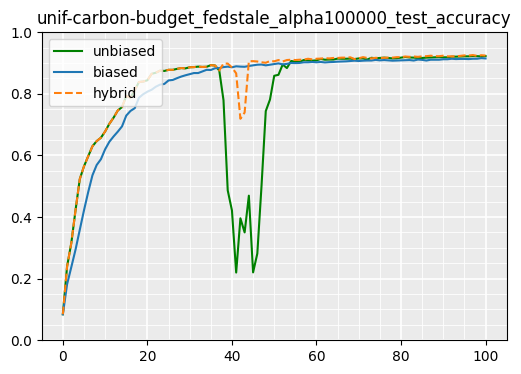

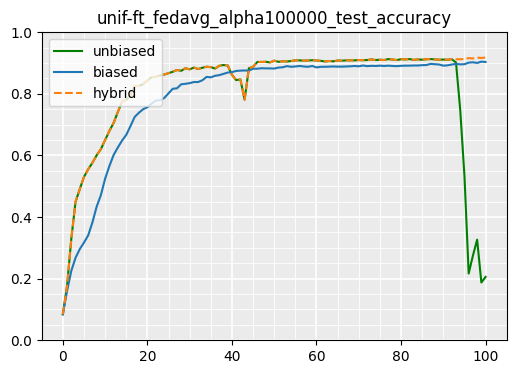

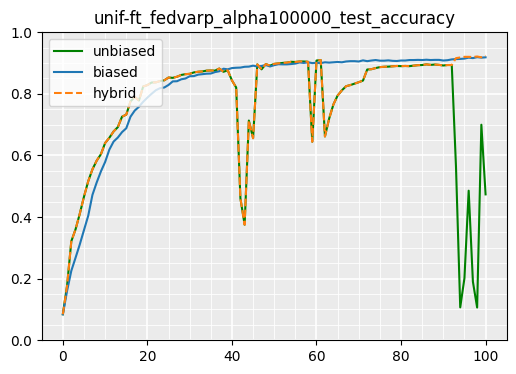

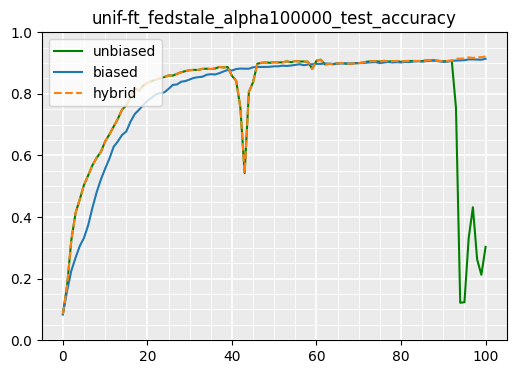

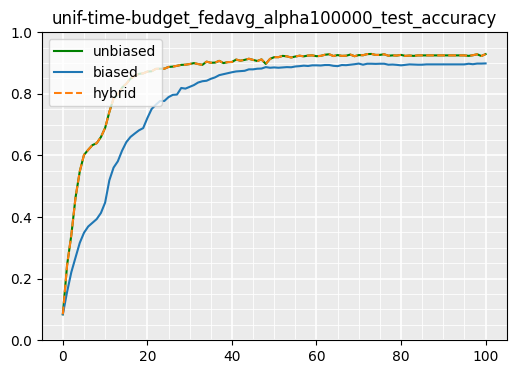

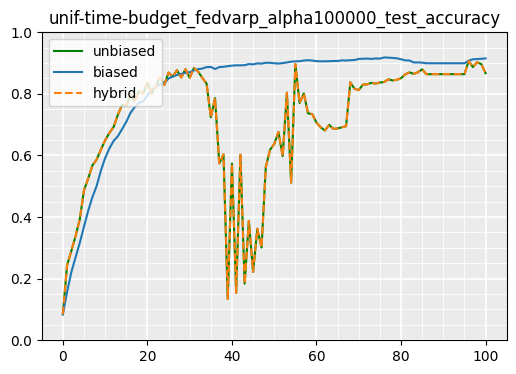

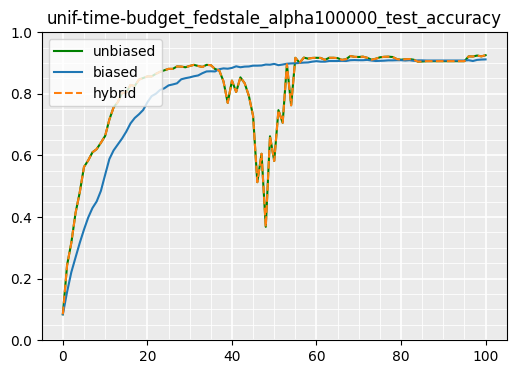

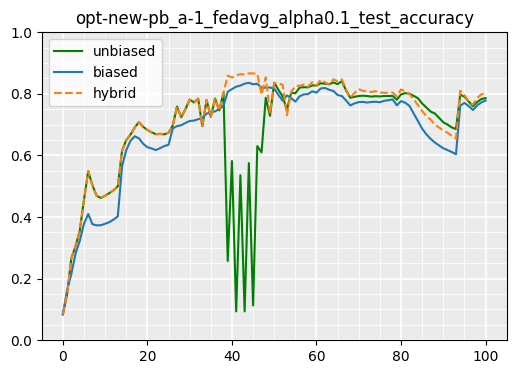

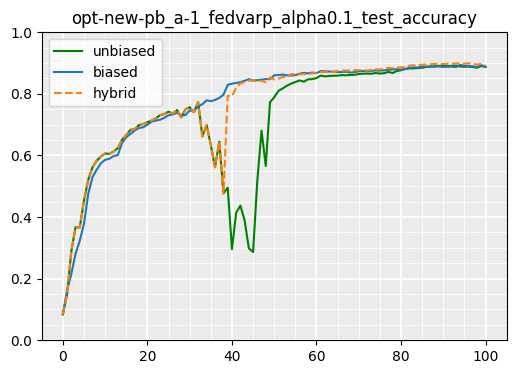

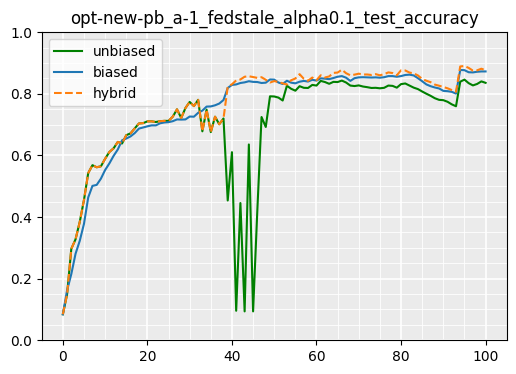

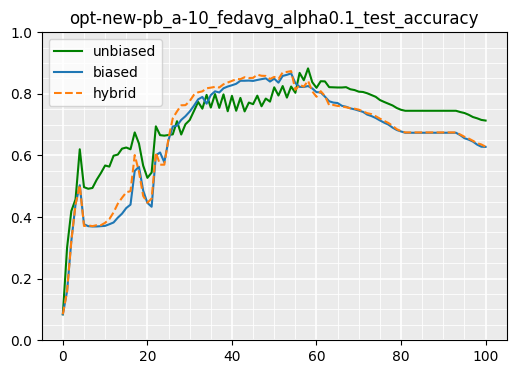

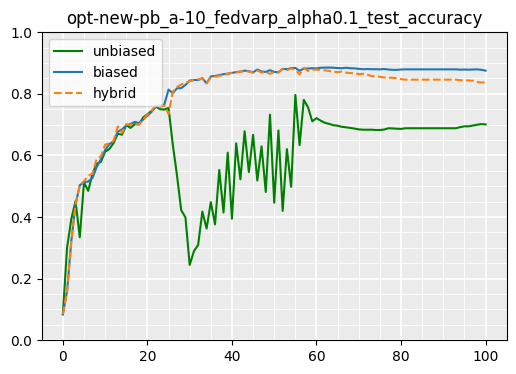

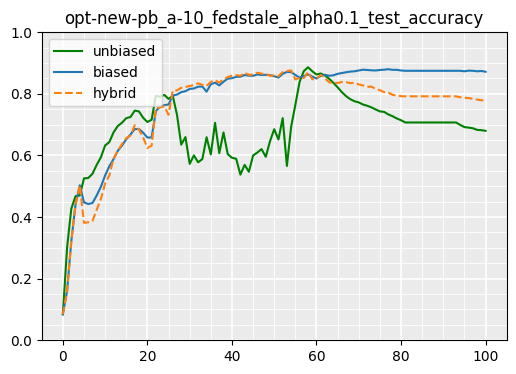

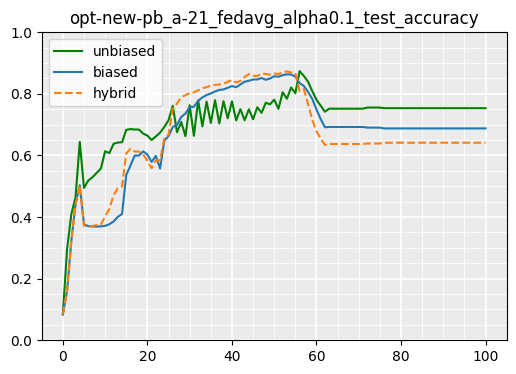

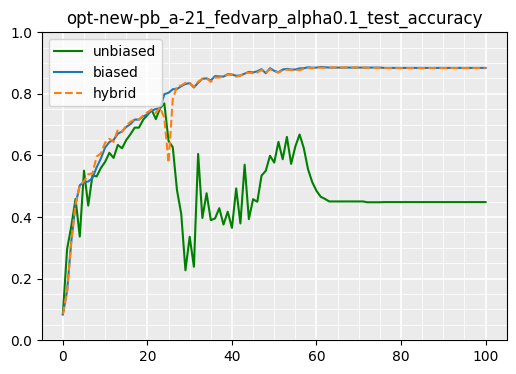

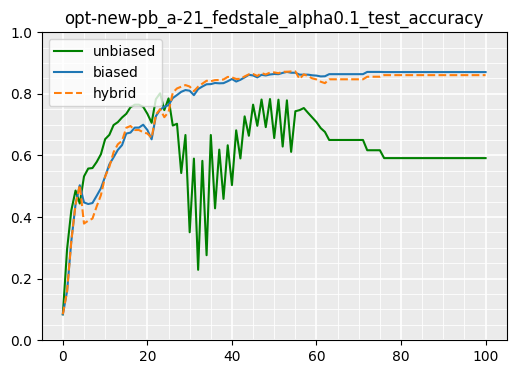

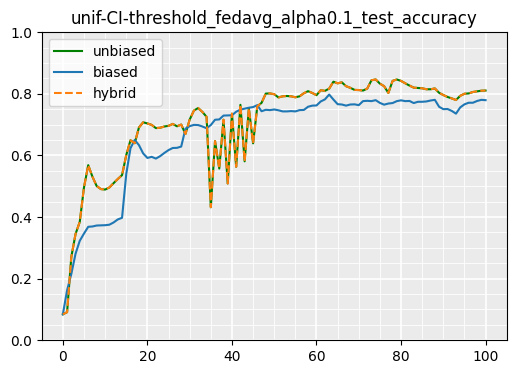

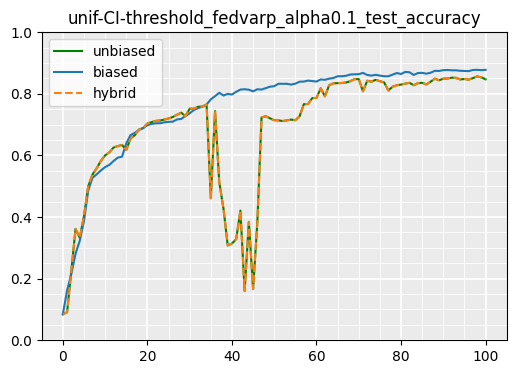

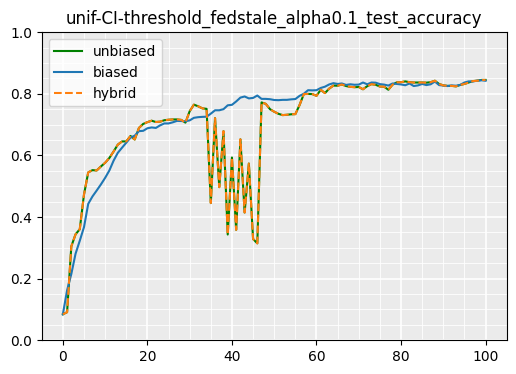

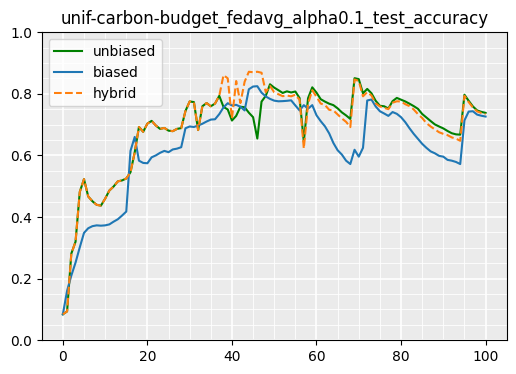

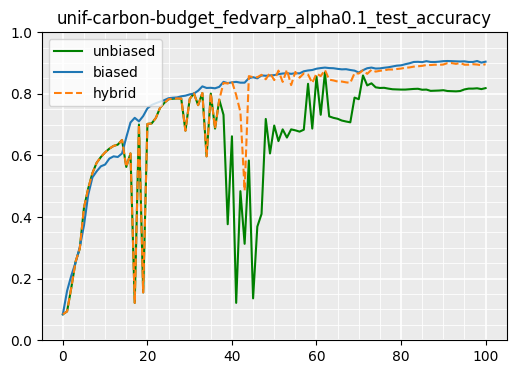

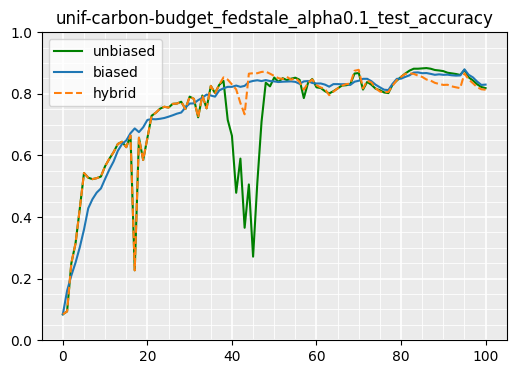

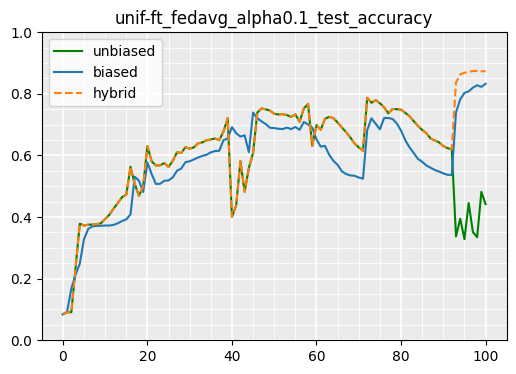

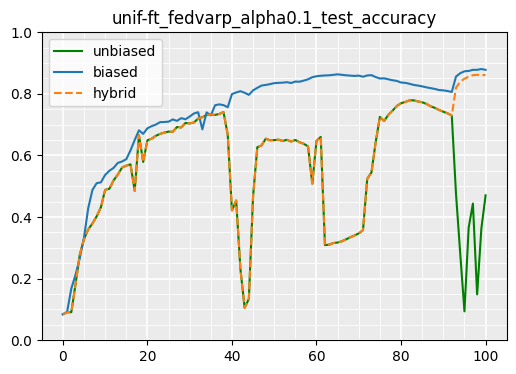

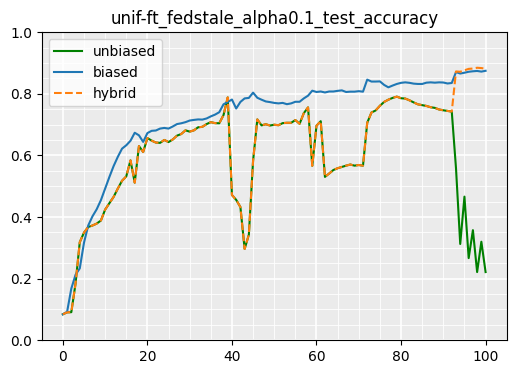

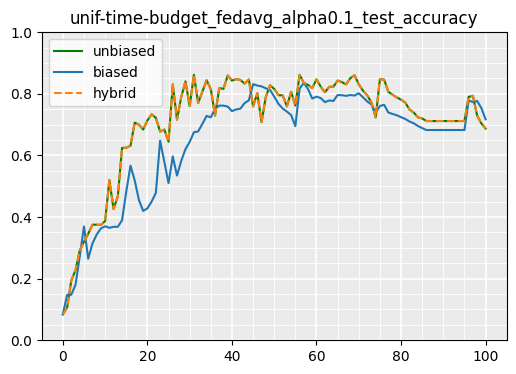

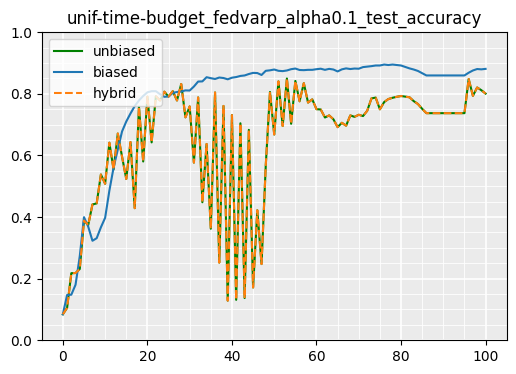

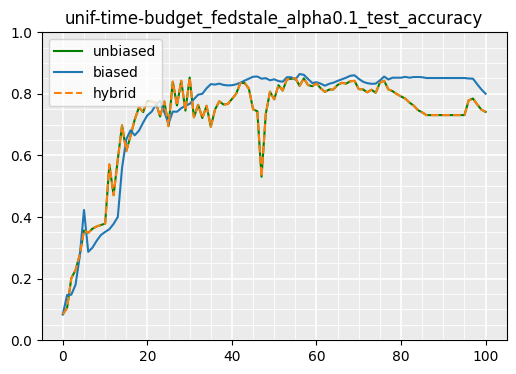

In [18]:
def plot_biased_unbiased_comparison(config, res, metric):

    
    xvalues = [i for i in range(int(config.n_rounds)+1)]

    for lr in config.lr_list:
        
        for event in config.events:
            for seed in config.seeds:
                for a in config.alphas:
                    for n_c in config.n_clients_list:
                        # for av in config.availabilities:
                        for part in config.participations:
                                    
                            for av in config.availabilities:

                                for algo in config.algorithms:

                                    res_tmp = res[(res.lr == lr) & (res.availability == av) & (res.event == event) &
                                                (res.seed == seed) & (res.alpha == a) & (res.n_clients == n_c) &
                                                (res.participation == part) & (res.algorithm == algo)]
                                    
                                    # display(res_tmp) # this is what we are going to compare
                                    
                                    fig = plt.figure(figsize=(6, 4))
                                    
                                    
                                    for biased in config.biased_list:
                                        
                                        res_plot = res_tmp[res_tmp.biased == biased]
                                        event_dir = config.get_event_dir(algo, lr, seed, 
                                                                        event, a, n_c, av, 
                                                                        config.n_rounds, part, biased)  
                                        # display(res_plot)
                                        # print('xxx')
                                        tag = res_plot[metric].values[0]
                                        _, test_accuracy_values = parse_tf_events_file(event_dir, tag=tag)
                                        # print(av)
                                        # yvalues = res_plot[(res_plot.availability == av)][metric]
                                        # print(res_plot[(res_plot.availability == av)][metric])
                                        
                                        if biased == "0":
                                            plt.plot(xvalues, test_accuracy_values, label="unbiased", color='g')
                                        elif biased == "1":
                                            plt.plot(xvalues, test_accuracy_values, label="biased")
                                        else:
                                            plt.plot(xvalues, test_accuracy_values, label="hybrid", linestyle="--")
                                        ax = plt.gca()
                                        ax.set_ylim([0, 1])
                                        # title = ('_').join([av.replace("random_for", "R"), algo, 'alpha'+a, metric])
                                        title = ('_').join([av.replace("random_for", "R").replace("carbon-budget-", "").replace("uniform", "unif").replace("problem-cvxpy", "pb"), algo, 'alpha'+a, metric])
                                        plt.title(title)
                                    plt.legend(loc='upper left')
                                    

                                    ax = plt.gca()
                                    ax.set_facecolor('#EBEBEB')
                                    ax.grid(which='major', color='white', linewidth=1.2)
                                    ax.grid(which='minor', color='white', linewidth=0.6)
                                    # Show the minor ticks and grid.
                                    ax.minorticks_on()
                                    # Now hide the minor ticks (but leave the gridlines).
                                    ax.tick_params(which='minor', bottom=False, left=False)
                                    

                                    # plt.grid()
                                    plt.savefig('figures/biased_vs_unbiased/'+title+'.png', bbox_inches='tight')
                                    plt.show()
    
plot_biased_unbiased_comparison(config, results_df, "test_accuracy")

In [19]:
# fig = plt.figure(figsize=(8, 4))

# for country_idx, country in enumerate(countries):

#     df_country = _dfs[country]
#     df_to_plot = df_country[df_country['datetime'].between(start_date,end_date)]

#     # plot:
#     plt.plot(df_to_plot['datetime'].values, df_to_plot['CI_direct'].values, label=country, color = list_colors[country_idx])

#     # plot legend, axis, etc.:
#     # ax.set_xlim([df_to_plot['datetime'].values[0], df_to_plot['datetime'].values[-1]])
#     plt.title('Carbon Intensity time evolution')
#     plt.legend()
#     # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))
#     # ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
#     _ = plt.xticks(rotation=90)  
#     plt.grid()
#     plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
#     plt.ylabel('CI (gCO2eq/kWh)')
# plt.savefig(os.path.join('figures/raw_CI_data.png'), bbox_inches='tight')

## Appendix

In [20]:
# folder = './logs/mnist_CI_based_availability/clients_7/local_mean/fedavg/known_participation_probs/alpha_0.1/lr_5e-3/seed_12/rounds_100/train/global/events.out.tfevents.1717493789.C11-8C4G9B45HOX.12548.7'
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
# event_acc = EventAccumulator(folder)
# event_acc.Reload()
# print(event_acc.Tags()) # Show all tags in the log file
# event_acc.Scalars('Train/Loss')

In [21]:
# from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# def parse_tf_events_file(events_path, tag, time_horizon=None):
#     # extract the list of steps (FL rounds) and the list or corresponding values
#     ea = EventAccumulator(events_path).Reload()
#     tag_values, steps = [], []
#     for event in ea.Scalars(tag):
#         if time_horizon is None or event.step <= time_horizon:
#             tag_values.append(event.value)
#             steps.append(event.step)
#     return steps, tag_values


# class ExperimentConfig:
#     def __init__(self, base_path, experiment, seeds, algorithms, events, heterogeneities, b_values, lr_dict
#                  ):
#         self.base_path = base_path
#         self.experiment = experiment
#         self.seeds = seeds
#         self.algorithms = algorithms
#         self.events = events
#         self.heterogeneities = heterogeneities
#         self.b_values = b_values
#         self.lr_dict = lr_dict

#     def get_event_dir(self, p, h, algorithm, lr, b, seed, event):
#         path = f"{self.base_path}/{self.experiment}/p_{p}/h_{h}"
#         path += f"/{algorithm}/b_{b}" if algorithm == "mixture" else f"/{algorithm}"
#         path += f"/lr_{lr}/seed_{seed}/train/{event}"
#         return path

# parse_tf_events_file(folder, 'Train/Loss')